# google drive

In [ ]:
from google.colab import drive 
drive.mount("/content/gdrive", force_remount=True)
os.chdir("/content/gdrive/MyDrive/explanations-for-computer-vision/")


In [ ]:
!pip install lime

# Object detector

In [1]:
import os

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, fasterrcnn_resnet50_fpn
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from lime.lime_image import LimeImageExplainer
from src.faster_rcnn import fasterrcnn_resnet18_fpn

from src.utils import jaccard

device = 'cpu'

# our dataset has two classes only - background and person
num_classes = 2

In [2]:
# load an instance segmentation model pre-trained pre-trained on COCO
# model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, num_classes=num_classes)
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, num_classes=num_classes)
model = fasterrcnn_resnet18_fpn(pretrained_backbone=True, num_classes=num_classes)
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# load model checkpoint
path = os.path.join(os.getcwd(), "./checkpoints/faster_rcnn_resnet1830_epochs.ckpt")
checkpoint = torch.load(path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

model.to(device) 

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride

In [3]:
import sys
sys.path.append("./detection")
from pennfudan_dataset import PennFudanDataset, get_transform

# use our dataset and defined transformations
dataset = PennFudanDataset('./PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('./PennFudanPed', get_transform(train=False))
# changing to array


# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

In [4]:
#creating test image



# Explanations

In [5]:
from src.sodexplainer import SODExplainer
explainer_sodex = SODExplainer(model=model)

## Lime Explanation

In [20]:
image_test = dataset_test[0][0]
image_test = image_test.permute(1,2,0).detach().numpy()
image_test = image_test.astype('double')

In [21]:
explanation = explainer_sodex.get_lime_explanation(image_test,dataset_test[0], num_samples=100000)

  0%|          | 0/1000 [00:00<?, ?it/s]

tensor([[0.8852]])
tensor([[0.9043]])
tensor([[0.9044]])
tensor([[0.8333]])
tensor([[0.9313]])
tensor([[0.8871]])
tensor([[0.8984]])
tensor([[0.8883]])
tensor([[0.8978]])
tensor([[0.8602]])
tensor([[0.8711]])
tensor([[0.9192]])
tensor([[0.8085]])
tensor([[0.8101]])
tensor([[0.8373]])
tensor([[0.9108]])
tensor([[0.8890]])
tensor([[0.8731]])
tensor([[0.8980]])
tensor([[0.8942]])
tensor([[0.9027]])
tensor([[0.8725]])
tensor([[0.9306]])
tensor([[0.9522]])
tensor([[0.8400]])
tensor([[0.9189]])
tensor([[0.8797]])
tensor([[0.8849]])
tensor([[0.9196]])
tensor([[0.8853]])
tensor([[0.7577]])
tensor([[0.9294]])
tensor([[0.8558]])
tensor([[0.8502]])
tensor([[0.8946]])
tensor([[0.7847]])
tensor([[0.8735]])
tensor([[0.7727]])
tensor([[0.9127]])
tensor([[0.9334]])
tensor([[0.9418]])
tensor([[0.8626]])
tensor([[0.8410]])
tensor([[0.8559]])
tensor([[0.8759]])
tensor([[0.8781]])
tensor([[0.8394]])
tensor([[0.8477]])
tensor([[0.8073]])
tensor([[0.8741]])
tensor([[0.7197]])
tensor([[0.9190]])
tensor([[0.7

(-0.5, 607.5, 473.5, -0.5)

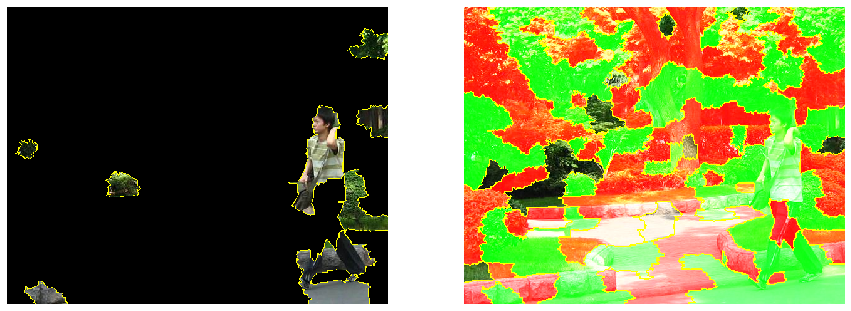

In [22]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=20, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=200, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

## Rise explanation

In [8]:
image_test = dataset_test[0][0].permute(1,2,0)
image_test = image_test.detach().numpy()
image_test = image_test.astype('double')
sal, preds, masks = explainer_sodex.get_rise_explanation(torch.from_numpy(image_test),dataset_test[0], N=1000, s=8, p1=0.5)

Explaining: 100%|███████████████████████████| 1000/1000 [25:47<00:00,  1.55s/it]

1058


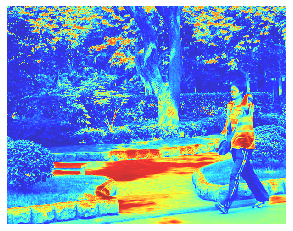

In [25]:
import matplotlib.pyplot as plt
import numpy as np

plt.axis('off')
plt.imshow(sal, cmap='jet', alpha=0.8)
plt.show()

In [11]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])



In [23]:
from PIL import Image, ImageDraw

result = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
image = ImageDraw.Draw(result)  

#for bbox in prediction[0]["boxes"]:
#    image.rectangle(bbox.cpu().numpy().tolist(), outline ="red")



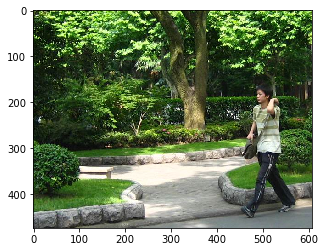

In [24]:
plt.imshow(result)